# Overview

In this notebook, we will go through the task generation pipeline in LIBERO. We will cover the following contents:

1. Retrieve a list of available objects, predicates
 in the codebase
2. Define your own initial state distribution
3. Define your own task goal
4. Generate the pddl file for the task

Now, let's get started!

## 1. Retrieve a list of objects available

In order for the sucess in task generation, we need to make sure that the objects and the predicates (object relations) specified are available in the codebase.

In [1]:
from libero.libero.envs.objects import get_object_dict, get_object_fn

# Get a dictionary of all the objects
object_dict = get_object_dict()
print(object_dict)

[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python /home/yygx/anaconda3/envs/libero/lib/python3.8/site-packages/robosuite/scripts/setup_macros.py (macros.py:55)


{'alphabet_soup': <class 'libero.libero.envs.objects.hope_objects.AlphabetSoup'>, 'bbq_sauce': <class 'libero.libero.envs.objects.hope_objects.BbqSauce'>, 'butter': <class 'libero.libero.envs.objects.hope_objects.Butter'>, 'cherries': <class 'libero.libero.envs.objects.hope_objects.Cherries'>, 'chocolate_pudding': <class 'libero.libero.envs.objects.hope_objects.ChocolatePudding'>, 'cookies': <class 'libero.libero.envs.objects.hope_objects.Cookies'>, 'corn': <class 'libero.libero.envs.objects.hope_objects.Corn'>, 'cream_cheese': <class 'libero.libero.envs.objects.hope_objects.CreamCheese'>, 'ketchup': <class 'libero.libero.envs.objects.hope_objects.Ketchup'>, 'macaroni_and_cheese': <class 'libero.libero.envs.objects.hope_objects.MacaroniAndCheese'>, 'mayo': <class 'libero.libero.envs.objects.hope_objects.Mayo'>, 'milk': <class 'libero.libero.envs.objects.hope_objects.Milk'>, 'orange_juice': <class 'libero.libero.envs.objects.hope_objects.OrangeJuice'>, 'popcorn': <class 'libero.libero.e

Now you can see all the available objects, you can retrieve the object class by specifying their categories (which are the keys in the dictionary)

In [2]:
category_name = "moka_pot"
object_cls = get_object_fn(category_name)
print(category_name, ": defined in the class ", object_cls)

moka_pot : defined in the class  <class 'libero.libero.envs.objects.turbosquid_objects.MokaPot'>


Similarly, you can retrieve the information about predicates.

In [3]:
from libero.libero.envs.predicates import get_predicate_fn_dict, get_predicate_fn

predicate_dict = get_predicate_fn_dict()
print(predicate_dict)
print("=============")
predicate_name = "on"
print(get_predicate_fn(predicate_name))


{'true': <libero.libero.envs.predicates.base_predicates.TruePredicateFn object at 0x7fe480f1c070>, 'false': <libero.libero.envs.predicates.base_predicates.FalsePredicateFn object at 0x7fe480f1c0a0>, 'in': <libero.libero.envs.predicates.base_predicates.In object at 0x7fe480f1c0d0>, 'on': <libero.libero.envs.predicates.base_predicates.On object at 0x7fe480f1c130>, 'up': <libero.libero.envs.predicates.base_predicates.Up object at 0x7fe480f1c100>, 'printjointstate': <libero.libero.envs.predicates.base_predicates.PrintJointState object at 0x7fe480f1c3d0>, 'open': <libero.libero.envs.predicates.base_predicates.Open object at 0x7fe480f1c4c0>, 'close': <libero.libero.envs.predicates.base_predicates.Close object at 0x7fe480f1c5b0>, 'turnon': <libero.libero.envs.predicates.base_predicates.TurnOn object at 0x7fe480f1c6a0>, 'turnoff': <libero.libero.envs.predicates.base_predicates.TurnOff object at 0x7fe480f1c7c0>}


## 2. Define your own initial state distribution

In [4]:
import numpy as np
from libero.libero.utils.bddl_generation_utils import get_xy_region_kwargs_list_from_regions_info
from libero.libero.utils.mu_utils import register_mu, InitialSceneTemplates
from libero.libero.utils.task_generation_utils import register_task_info, get_task_info, generate_bddl_from_task_info

@register_mu(scene_type="kitchen")
class KitchenScene1(InitialSceneTemplates):
    def __init__(self):

        fixture_num_info = {
            "kitchen_table": 1,
            "wooden_cabinet": 1,
        }

        object_num_info = {
            "akita_black_bowl": 1,
            "plate": 1,
        }

        super().__init__(
            workspace_name="kitchen_table",
            fixture_num_info=fixture_num_info,
            object_num_info=object_num_info
        )

    def define_regions(self):
        self.regions.update(
            self.get_region_dict(region_centroid_xy=[0.0, -0.30],
                                 region_name="wooden_cabinet_init_region",
                                 target_name=self.workspace_name,
                                 region_half_len=0.01,
                                 yaw_rotation=(np.pi, np.pi))
        )

        self.regions.update(
            self.get_region_dict(region_centroid_xy=[0., 0.0], 
                                 region_name="akita_black_bowl_init_region", 
                                 target_name=self.workspace_name, 
                                 region_half_len=0.025)
        )

        self.regions.update(
            self.get_region_dict(region_centroid_xy=[0.0, 0.25], 
                                 region_name="plate_init_region", 
                                 target_name=self.workspace_name, 
                                 region_half_len=0.025)
        )
        self.xy_region_kwargs_list = get_xy_region_kwargs_list_from_regions_info(self.regions)

    @property
    def init_states(self):
        states = [
            ("On", "akita_black_bowl_1", "kitchen_table_akita_black_bowl_init_region"),
            ("On", "plate_1", "kitchen_table_plate_init_region"),
            ("On", "wooden_cabinet_1", "kitchen_table_wooden_cabinet_init_region")]
        return states

## 3. Define your own task goal

Now that you've defined the initial state distributions, you can specify a task goal based on the available objects and the potential goals it can acehive.

In [5]:
scene_name = "kitchen_scene1"
language = "Your Language 1"
register_task_info(language,
                    scene_name=scene_name,
                    objects_of_interest=["wooden_cabinet_1", "akita_black_bowl_1"],
                    goal_states=[("Open", "wooden_cabinet_1_top_region"), ("In", "akita_black_bowl_1", "wooden_cabinet_1_top_region")]
)

# Create another task with the same scene layout
scene_name = "kitchen_scene1"
language = "Your Language 2"
register_task_info(language,
                    scene_name=scene_name,
                    objects_of_interest=["wooden_cabinet_1", "akita_black_bowl_1"],
                    goal_states=[("Open", "wooden_cabinet_1_top_region"), ("In", "akita_black_bowl_1", "wooden_cabinet_1_bottom_region")]
)

The task goals will be temporarily saved in the variable `libero.libero.utils.task_generation_utils.TASK_INFO` in the format of namedtuple `libero.libero.utils.task_generation_utils.TaskInfoTuple`. This design aims to make it easy for batch creation of tasks.

In [6]:
# This is the default path to store all the pddl scene files. Here we store the files in the temporary folder. If you want to directly add files into the libero codebase, get the default path use the following commented lines:
# from libero.libero import get_libero_path
# YOUR_BDDL_FILE_PATH = get_libero_path("bddl_files")

YOUR_BDDL_FILE_PATH = "tmp/pddl_files"
bddl_file_names, failures = generate_bddl_from_task_info(folder=YOUR_BDDL_FILE_PATH)

print(bddl_file_names)

print("Encountered some failures: ", failures)


Succefully generated: 2
['tmp/pddl_files/KITCHEN_SCENE1_your_language_1.bddl', 'tmp/pddl_files/KITCHEN_SCENE1_your_language_2.bddl']
Encountered some failures:  []


Now you can see the content of the pddl file name. (Notice that we named our variable with bddl, since we are actually using the bddl package from Behavior. However, bddl is a subset of pddl, so we stick to the word PDDL for consistency in our paper writing and avoid confusion to the community.)

In [7]:
with open(bddl_file_names[0], "r") as f:
    content = f.read()
print(content)

(define (problem LIBERO_Kitchen_Tabletop_Manipulation)
  (:domain robosuite)
  (:language Your Language 1)
    (:regions
      (wooden_cabinet_init_region
          (:target kitchen_table)
          (:ranges (
              (-0.01 -0.31 0.01 -0.29)
            )
          )
          (:yaw_rotation (
              (3.141592653589793 3.141592653589793)
            )
          )
      )
      (akita_black_bowl_init_region
          (:target kitchen_table)
          (:ranges (
              (-0.025 -0.025 0.025 0.025)
            )
          )
          (:yaw_rotation (
              (0.0 0.0)
            )
          )
      )
      (plate_init_region
          (:target kitchen_table)
          (:ranges (
              (-0.025 0.225 0.025 0.275)
            )
          )
          (:yaw_rotation (
              (0.0 0.0)
            )
          )
      )
      (top_side
          (:target wooden_cabinet_1)
      )
      (top_region
          (:target wooden_cabinet_1)
      )
      (middl

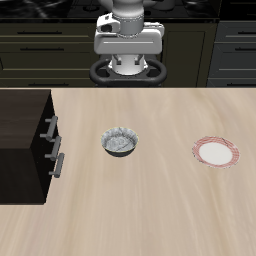

In [8]:
from libero.libero.envs import OffScreenRenderEnv
from IPython.display import display
from PIL import Image

import torch
import torchvision


env_args = {
    "bddl_file_name": bddl_file_names[0],
    "camera_heights": 256,
    "camera_widths": 256
}

env = OffScreenRenderEnv(**env_args)
obs = env.reset()
display(Image.fromarray(obs["agentview_image"][::-1]))